In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage
from pathlib import Path
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import sys
sys.path.append("../") 
sys.path.append("../neural_style") 
%load_ext autoreload
%autoreload 2
from neural_style.neural_style import *
from neural_style import utils

ROOT_DIR = Path('../')
IMGS_PATH = ROOT_DIR/'images/'

PS_ROOT_DIR =  Path('../../storage/style-transfer/')
DATA_PATH = PS_ROOT_DIR/'images/'
MODEL_PATH = PS_ROOT_DIR/'models/'
os.makedirs(DATA_PATH,exist_ok=True)
os.makedirs(MODEL_PATH,exist_ok=True)

device = torch.device("cuda")

In [2]:
# free cuda
#transformer.zero_grad()
torch.cuda.empty_cache()

In [3]:
t = torch.cuda.get_device_properties(0).total_memory
a = torch.cuda.memory_allocated(0)
a/t

0.0

In [ ]:
def load_style_model(m_path):
    with torch.no_grad():
        style_model = TransformerNet()
        state_dict = torch.load(m_path)
        for k in list(state_dict.keys()):
            if re.search(r'in\d+\.running_(mean|var)$', k):
                del state_dict[k]
        style_model.load_state_dict(state_dict)
        style_model.to(device)
    return style_model

def load_content_img(img_path,scale=4):
    content_image = utils.load_image(img_path, scale=scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    return content_image.unsqueeze(0).to(device)

def style_img(content_image):
    with torch.no_grad():
        output = style_model(content_image).cpu()
    img = output[0].clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = pilImage.fromarray(img)
    return img

## Experiment with Existing Models

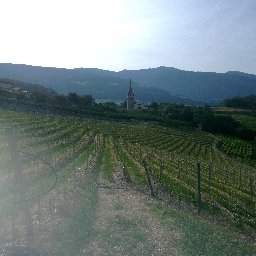

In [4]:
img_path = IMGS_PATH/'content-images/weingart_bright.jpg'
img = pilImage.open(img_path)
img.resize((256,256),pilImage.NEAREST)

In [11]:
if not os.path.exists(MODEL_PATH/'saved_models/candy.pth'):
    import zipfile
    try:
        from torch.utils.model_zoo import _download_url_to_file
    except ImportError:
        try:
            from torch.hub import download_url_to_file as _download_url_to_file
        except ImportError:
            from torch.hub import _download_url_to_file


    def unzip(source_filename, dest_dir):
        with zipfile.ZipFile(source_filename) as zf:
            zf.extractall(path=dest_dir)

    _download_url_to_file('https://www.dropbox.com/s/lrvwfehqdcxoza8/saved_models.zip?dl=1', MODEL_PATH/'saved_models.zip', None, True)
    unzip(MODEL_PATH/'saved_models.zip', MODEL_PATH)

In [185]:
# to use self trained model
m_path = MODEL_PATH/'checkpoints/ckpt_epoch_0_batch_id_24000.pth'
style_model = load_style_model(m_path)

In [186]:
from ipywidgets import interact
    
def cut_img(img,h_s,h_e,w_s,w_e):
    return content_image[:,:,h_s:h_e,w_s:w_e]

def style_cut(h_s,h_e,w_s,w_e): 
    img = style_img(cut_img(content_image,h_s,h_e,w_s,w_e))
    display(img)

content_image = load_content_img(IMGS_PATH/'content-images/weingart_bright.jpg', scale=4)

In [187]:
#not sure why it's so slow here, works way better on Colab
interact(style_cut,
        h_s=widgets.IntSlider(min=0, max=content_image.shape[2], step=10, value=0),
        h_e=widgets.IntSlider(min=0, max=content_image.shape[2], step=10, value=content_image.shape[2]),
        w_s=widgets.IntSlider(min=0, max=content_image.shape[3], step=10, value=0),
        w_e=widgets.IntSlider(min=0, max=content_image.shape[3], step=10, value=content_image.shape[3]))

interactive(children=(IntSlider(value=0, description='h_s', max=992, step=10), IntSlider(value=992, descriptio…

<function __main__.style_cut(h_s, h_e, w_s, w_e)>

# Training
## Style-Transfer

In [6]:
from fastai.vision.all import *

In [9]:
content_weight = 1e5*2
style_weight = 1e10
img_size = 256
bs = 4

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

In [10]:
mse_loss = torch.nn.MSELoss()

vgg = Vgg16(requires_grad=False).to(device)
style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

style = utils.load_image(IMGS_PATH/"style-images/vangogh_wheat_field.jpg", size=512)
style = style_transform(style)
style = style.repeat(bs, 1, 1, 1).to(device)

features_style = vgg(utils.normalize_batch(style))
gram_style = [utils.gram_matrix(y) for y in features_style]

In [16]:
def style_transfer_loss(y, x):
    y = utils.normalize_batch(y)
    x = utils.normalize_batch(x)

    features_y = vgg(y)
    features_x = vgg(x)

    content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)

    style_loss = 0.
    n_batch = len(x) #in case last batch has not bs size
    for ft_y, gm_s in zip(features_y, gram_style):
        gm_y = utils.gram_matrix(ft_y)
        style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])
    style_loss *= style_weight

    total_loss = content_loss + style_loss
    return total_loss

class STLoss(nn.Module):
    def __init__(self, ):
        super().__init__()
              
    def forward(self, y, x):
        return style_transfer_loss(y,x)

In [17]:
class LimitDS(datasets.ImageFolder):
    def __init__(self, length, *args):
        super().__init__(*args)
        self.length = length
    def __getitem__(self, i):
        x = super().__getitem__(i)
        return x[0],x[0]
    def __len__(self):
        return self.length
#train_ds = datasets.ImageFolder('../../storage/style-transfer/data/', transform)
train_ds = LimitDS(4*50, '../../storage/style-transfer/images/', transform)
dls = DataLoaders.from_dsets(train_ds, bs=4,device='cuda')

In [18]:
content_image = load_content_img(img_path, scale=4)
content_image = content_image[:,:,200:712,200:712]
#my_val_func()

In [19]:
def transform_img(model, img):
    with torch.no_grad():
        output = model(img).cpu()
    img = output[0].clone().clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    img = pilImage.fromarray(img)
    return img
def my_val_func():
    img = transform_img(learn.model, content_image)
    image_list.append(img)
    display(img)
    return None
def generate_gif(image_list,gif_path):
    #transform to images, add backward loop and store as gif
    first_img, *imgs = image_list
    imgs += [img for img in imgs[::-1]]
    first_img.save(fp=gif_path, format='GIF', append_images=imgs, save_all=True, duration=1000, loop=0)


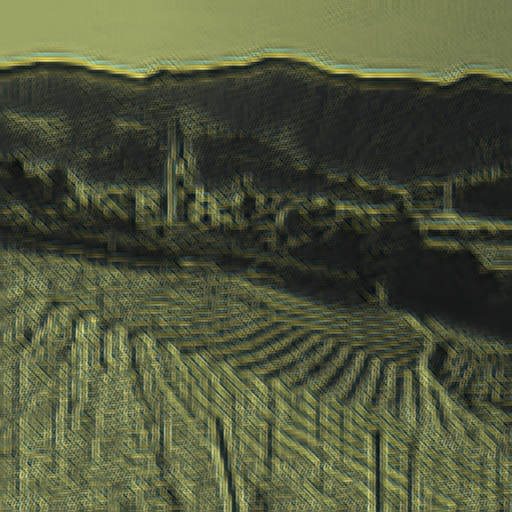

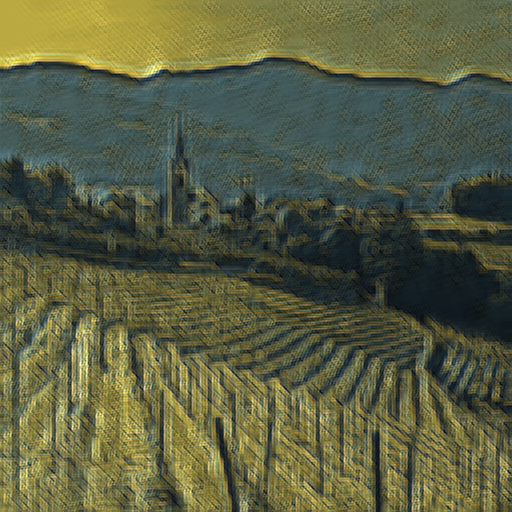

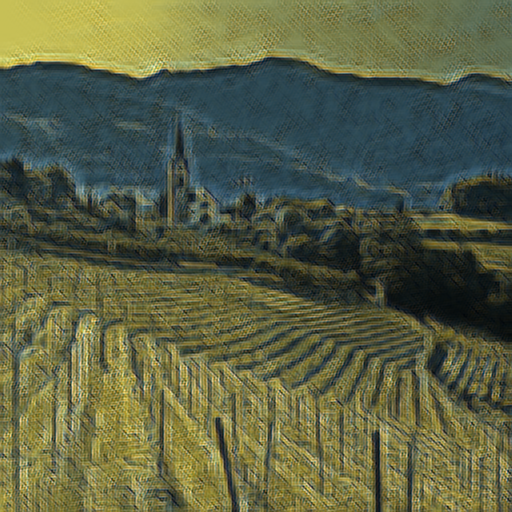

In [20]:
image_list = []

transformer = TransformerNet().to(device)
learn = Learner(dls, transformer, loss_func=STLoss())
learn._do_epoch_validate = my_val_func
learn.fit_one_cycle(3, 0.01)

In [124]:
generate_gif(image_list,IMGS_PATH/'train_progress_style_transfer.gif')

In [125]:
#os.makedirs(MODEL_PATH/'style_transfer',exist_ok=True)
#torch.save(transformer.state_dict(), MODEL_PATH/'style_transfer'/'exp_1')
#test_model = load_style_model(MODEL_PATH/'style_transfer'/'exp_1')
#test_model = test_model.eval()
#transform_img(test_model, img)

In [133]:
# to compare with other models
#m_path = MODEL_PATH/'checkpoints/ckpt_epoch_0_batch_id_500.pth'
#style_model = load_style_model(m_path)
#
##style_model = learn.model#load_style_model(MODEL_PATH/'saved_models/candy.pth')#
#transform_img(style_model, load_content_img(img_path, scale=1))

## Super Resolution

In [ ]:
content_weight = 1e5*2
img_size = 256

transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.CenterCrop(img_size),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255))
])

In [58]:
def style_transfer_loss(y, x):
    y = utils.normalize_batch(y)
    x = utils.normalize_batch(x)
    
    features_y = vgg(y)
    features_x = vgg(x)
    
    content_loss = content_weight * mse_loss(features_y.relu2_2, features_x.relu2_2)
    return content_loss

class STLoss(nn.Module):
    def __init__(self, ):
        super().__init__()
              
    def forward(self, y, x):
        return style_transfer_loss(y,x)

In [175]:
with torch.no_grad():
    input,target = my_ds[0]
    input,target = input.unsqueeze(0).cuda(), target.unsqueeze(0).cuda()
    y = transformer(input)
    print(learn.loss_func(y,target))

tensor(458988., device='cuda:0')


In [15]:
content_image = load_content_img(img_path, scale=4)
content_image = content_image[:,:,200:712,200:712]

In [64]:
class SuperResolutionDS(datasets.ImageFolder):
    def __init__(self, length, down_sample, up_sample, *args):
        super().__init__(*args)
        self.length = length
        self.super_res_trans = transforms.Compose([transforms.Resize(down_sample),transforms.Resize(up_sample)])
    def __getitem__(self, i):
        x = super().__getitem__(i)
        return self.super_res_trans(x[0]),x[0]
    def __len__(self):
        return self.length

#train_ds = datasets.ImageFolder('../../storage/style-transfer/data/', transform)
train_ds = SuperResolutionDS(4*500, 64, 256, '../../storage/style-transfer/images/', transform)
dls = DataLoaders.from_dsets(train_ds, bs=16,device='cuda')


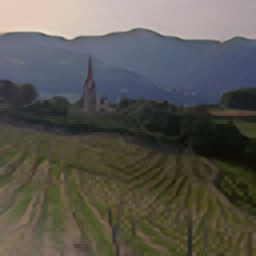

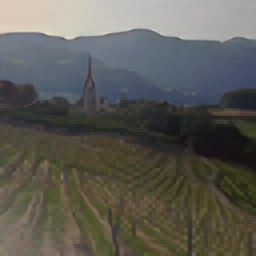

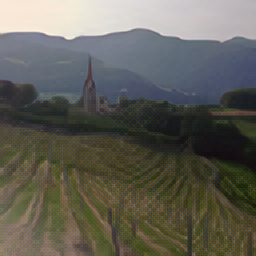

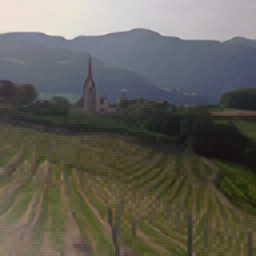

In [107]:
#transformer = TransformerNet().to(device)
learn = Learner(dls, transformer, loss_func=STLoss())
image_list = []
def my_val_func():
    img = transform_img(learn.model, dls.super_res_trans(content_image))
    image_list.append(img)
    display(img)
    return None
learn._do_epoch_validate = my_val_func
learn.fit_one_cycle(4, 0.01)

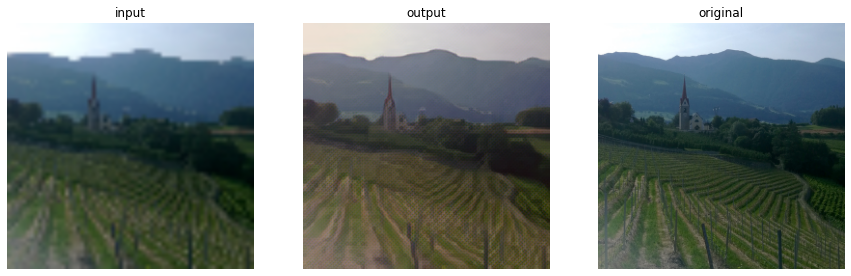

In [161]:
def torch_to_pil(x):
    return pilImage.fromarray(x.permute(1,2,0).detach().cpu().numpy().astype('uint8'))

def vis_results(x):
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    ax[0].imshow(torch_to_pil(dls.super_res_trans(x[0])))
    ax[1].imshow(transform_img(learn.model, dls.super_res_trans(x)))
    ax[2].imshow(torch_to_pil(transforms.Resize(256)(x[0])))
    ax[0].set_title('input')
    ax[1].set_title('output')
    ax[2].set_title('original')
    [axi.axis('off') for axi in ax]
    plt.show()
vis_results(content_image)

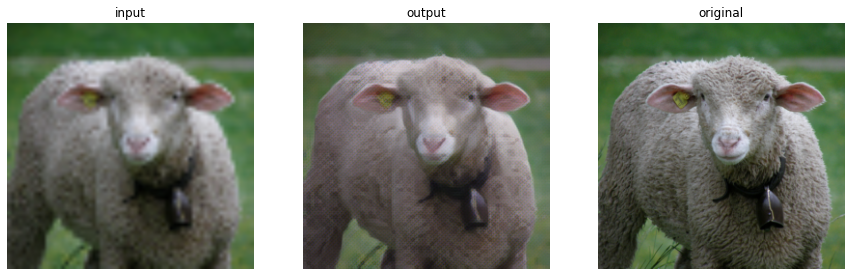

In [179]:
x,y = dls.one_batch()
vis_results(y[:1]) #need to call it on the target

In [124]:
generate_gif(image_list,IMGS_PATH/'train_progress_super_resolution.gif')

In [125]:
#os.makedirs(MODEL_PATH/'super_resolution',exist_ok=True)
#torch.save(transformer.state_dict(), MODEL_PATH/'super_resolution'/'exp_1')
#test_model = load_style_model(MODEL_PATH/'super_resolution'/'exp_1')
#test_model = test_model.eval()
#transform_img(test_model, img)

### End Super Resolution